# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from lungpetctdx_dataset import LungPetCtDxDataset_TumorPresence
from utils.wandb import start_wandb_run, wandb_watch, wandb_log
from eval.reconstruction_viusalization import compare_images


cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'pynvml module not found, please install pynvml'

# Defining datasets (train/validation) 

In [2]:
IMAGE_RESOLUTION = 128

In [3]:
from lungpetctdx_dataset import LungPetCtDxDataset_TumorPresence

postprocess = transforms.Compose([
    transforms.Grayscale()
])
ds = LungPetCtDxDataset_TumorPresence(post_normalize_transform=postprocess,
    normalize=True, cache=True)

trainSet, valSet = ds.subject_split(0.2)#random_split(ds, [0.8, 0.2])
dataloaders = {
    "val": torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=8),
    "train": torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=8),
}
num_classes = len(ds.class_names)
dataset_sizes = {"train": len(trainSet),"val": len(valSet)}

# Defining model 

In [4]:
from capsule_net import CapsNet
from capsnet_config import Config
config = Config(cnn_in_channels=1, input_width=IMAGE_RESOLUTION, input_height=IMAGE_RESOLUTION, dc_in_channels=392, reconstruction_loss_factor=0.4, dc_num_capsules=num_classes, out_capsule_size=16)

model = CapsNet(config)

start_wandb_run(config)

wandb_watch(model)
model.to(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tfiedlerdev (7-vs-capsule). Use `wandb login --relogin` to force relogin


CapsNet(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

# Setup training

In [5]:
from tqdm.notebook import tqdm
from utils.mask import mask_image

import numpy as np
def predicted_indices_from_outputs(outputs):
    classes = torch.sqrt((outputs ** 2).sum(2))
    _, max_length_indices = classes.max(dim=1)
    return torch.squeeze(max_length_indices, -1)


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = []
    batchEnumeration = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        epoch_result = {}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_corrects = 0
            running_losses = np.array([0,0,0], np.float32)

            # Iterate over data.
            for idx, (inputs, labels, bounding_boxes) in enumerate(dataloaders[phase]):
               
                reconstruction_target_images = torch.tensor(list(map(mask_image, inputs, bounding_boxes)))
                reconstruction_target_images = reconstruction_target_images.to(device)
            
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, reconstructions, _ = model(inputs)
                    preds = predicted_indices_from_outputs(outputs)
                    loss, classification_loss, reconstruction_loss = model.loss(reconstruction_target_images, outputs, labels, reconstructions, CEL_for_classifier=True)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_size = inputs.size(0)
                batch_loss = loss.item() * batch_size
                batch_classification_loss = classification_loss.item() * batch_size
                batch_reconstruction_loss = reconstruction_loss.item() * batch_size
                batch_losses = [batch_loss,batch_classification_loss, batch_reconstruction_loss]
                losses.append(batch_losses)
                batchEnumeration.append(batchEnumeration[-1]+1 if len(batchEnumeration)>0 else 0)

                running_losses += np.array(batch_losses)
                _, labels_index = torch.max(labels.data, 1)
                batch_num_correct = torch.sum(preds ==labels_index)
            
                running_corrects += batch_num_correct
                if idx % 10 == 0:
                    batch_size = inputs.size(0)
                    tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train acc: {:.6f}, batch loss: {:.6f}, running reconstr. loss: {:.6f}, running class. loss: {:.6f}".format(
                        epoch,
                        num_epochs,
                        idx + 1,
                        len(dataloaders[phase]),
                        batch_num_correct / float(batch_size),
                        batch_loss / float(batch_size), 
                        running_losses[2]/(idx+1), 
                        running_losses[1]/(idx+1)
                        ), end="\r")
                    
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_losses[0] / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]
            epoch_reconstruction_loss = running_losses[2] / dataset_sizes[phase]
            epoch_classification_loss =  running_losses[1]/ dataset_sizes[phase]

            epoch_result[phase] = {"acc": epoch_acc, "loss": epoch_loss, "classification_loss": epoch_classification_loss, "reconstruction_loss":epoch_reconstruction_loss}

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        wandb_log(epoch_result)
        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    figure, axis = plt.subplots(3)
    def plotLoss(lossIndex: int, title: str):
        axis[lossIndex].plot(batchEnumeration, [entry[lossIndex] for entry in losses])
        axis[lossIndex].set_title(title)
    
    for i, title in enumerate(["Combined Training losses", "Classification losses", "Reconstruction losses"]):
        plotLoss(i, title)
 

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Define training parameters

In [6]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run training

In [8]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------


# Evaluation

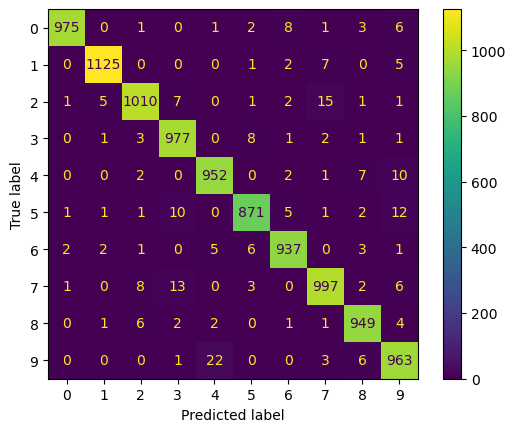

F1-score: 0.975617485857385


In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


y_true = np.array([])
y_pred = np.array([])
with torch.no_grad():
    #for i, (inputs, classes, bboxes) in enumerate(dataloaders['val']):
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        classes = torch.nn.functional.one_hot(classes, 10).type(torch.float32)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs, _, _ = model(inputs)
        
        
        preds = predicted_indices_from_outputs(outputs).cpu()
        _, labels = torch.max(classes.cpu(), 1)
    
        y_true = np.concatenate((y_true, preds))
        y_pred = np.concatenate((y_pred, labels))
        
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=ds["class_names"])
disp.plot()
plt.show()
print("F1-score:",f1_score(y_true, y_pred, average="weighted") )

# Visualize reconstruction samples


Inputs min 0.0 max 1.0 mean 0.11432791501283646 std 0.2898881137371063
reconstruction_targets min 0.0 max 1.0 mean 0.11432791501283646 std 0.2898881137371063
reconstructions min 5.248328307061456e-05 max 0.9755591750144958 mean 0.12025932222604752 std 0.20020554959774017
inputs shape torch.Size([32, 1, 28, 28])
reconstructions shape torch.Size([32, 1, 28, 28])


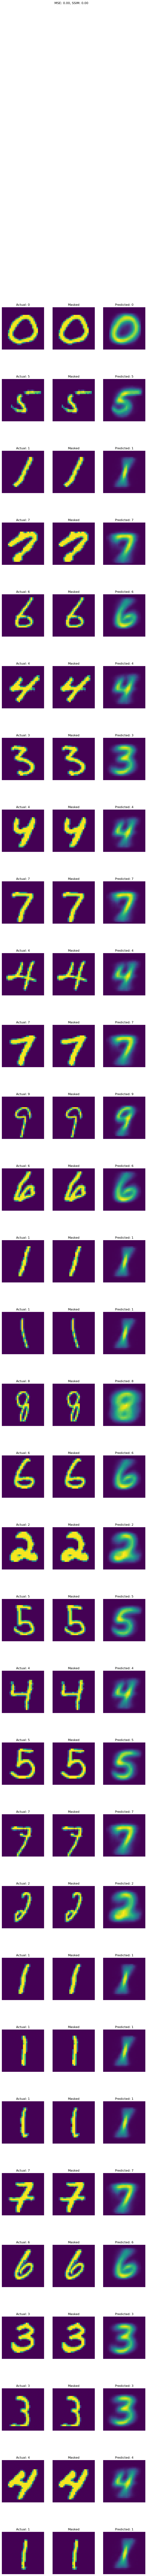

In [ ]:
with torch.no_grad():
    inputs, classes = next(iter(dataloaders['train']))
    #inputs, classes, bounding_boxes = next(iter(dataloaders['train'])) 
    #reconstruction_targets = torch.tensor(list(map(mask_image, inputs, bounding_boxes)))
    #reconstruction_targets = reconstruction_targets.to(device)
    classes = torch.nn.functional.one_hot(classes, 10).type(torch.float32)
    inputs = inputs.to(device)
    reconstruction_targets = inputs
    classes = classes.to(device)
    outputs, reconstructions, _ = model(inputs)
    preds = predicted_indices_from_outputs(outputs).cpu()
    _, labels = torch.max(classes.cpu(), 1)
    
    print("Inputs min",inputs.min().item(), "max", inputs.max().item(), "mean", inputs.mean().item(), "std", inputs.std().item())
    print("reconstruction_targets min",reconstruction_targets.min().item(), "max", reconstruction_targets.max().item(), "mean", reconstruction_targets.mean().item(), "std", reconstruction_targets.std().item())
    print("reconstructions min",reconstructions.min().item(), "max", reconstructions.max().item(), "mean", reconstructions.mean().item(), "std", reconstructions.std().item())
    print("inputs shape", inputs.size())
    print("reconstructions shape", reconstructions.size())
    compare_images([(inputs[i], reconstruction_targets[i],reconstructions[i]) for i in range(reconstructions.size(0))], preds, labels)

In [ ]:

reconstructions[0].min()


tensor(0.4750, device='cuda:0')

In [ ]:
#torch.save(model, "../results/capset_in128x128_2class_16outCapsChannels_adam_CEL_32epochs.p")

# Count classes

In [ ]:
numClass0 = 0
numClass1 = 0

#for i, (inputs, classes, bboxes) in enumerate(dataloaders['val']):
for i, (inputs, classes) in enumerate(dataloaders['val']):
    #_, labels = torch.max(classes.cpu(), 1)
    #batchNum1 = torch.sum(labels)
    #numClass1 += batchNum1
    #numClass0 += len(labels)-batchNum1
    print(inputs.size())
    break

print("Samples of class 0: ", numClass0)
print("Samples of class 1: ", numClass1)


torch.Size([32, 1, 28, 28])
Samples of class 0:  0
Samples of class 1:  0
